In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_Third_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Models/GDSC_PDX_TCGA_Third_Strategy/Third_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Figures/GDSC_PDX_TCGA_Third_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details = GDSC_cell_line_details.iloc[:-1,]
GDSC_cell_line_details.index = GDSC_cell_line_details.index.astype(str)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1299069,TMK-1,Y,Y,N,N,Y,digestive_system,stomach,STAD,,R,Adherent
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent


In [6]:
# change directory to read GDSC expression dataset (DNA_REPi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (DNA_REPi)
# remove samples with shared cancer types from training dataset

GDSCE = pd.read_csv("GDSC_exprs.z.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE = pd.merge(GDSC_cell_line_details,
                 GDSCE,
                 left_index=True,
                 right_index=True)
filter = (GDSCE["GDSC\nTissue descriptor 1"] != "pancreas") & \
         (GDSCE["GDSC\nTissue descriptor 1"] != "large_intestine") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "PAAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "STAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "READ") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "COREAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "ESCA")
GDSCE = GDSCE.loc[filter, ]
GDSCE.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCE.index = GDSCE.index.astype(int)

GDSCE.head(3)

,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
906794,-0.523146241125996,-0.4774107580335559,1.1792180707204845,-0.1950133103016388,0.2086331356678636,0.1512743407965193,-1.0570300318558898,0.1189857462468134,-1.60237161712403,0.0522097313574845,...,0.4777943283680773,1.7440832645129538,-0.1411845263288239,1.550275627132598,1.7625075247186934,-0.9885319787599142,-1.398962216984746,-1.1477981243123072,0.2309989847175704,0.1184597758225788
753531,-0.4224302754300224,-0.3242516223071998,-0.3208981588446875,-0.4397392179491251,3.025286158155485,-0.24438999503986,0.7515936357204973,0.0632614716673226,1.1869816204036372,0.910750698661622,...,0.5061734764924927,-1.0342661397324897,-0.4760165332952215,0.4559917131361604,-0.2809661852015279,0.7118421818299816,-0.346615229870122,-1.470020745651282,0.0534664475662629,-1.0214126092212672
753532,0.38120783287858,-0.216246760163162,-1.3542414608934643,-0.0288553253901928,-0.210475976908014,-0.2095800353031544,-0.6041666360277236,-0.3005598678634803,-1.0678335183424454,-0.3855263679950399,...,2.138001331301404,0.4656565668245515,-0.6052206632622278,2.411447606433391,0.2137155086353199,-1.1485572785697182,0.6297279321839303,-0.7263920504862745,0.5305975336134361,0.0576046675547845


In [8]:
# change directory to read GDSC mutation dataset (DNA_REPi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (DNA_REPi)
# remove samples with shared cancer types from training dataset

GDSCM = pd.read_csv("GDSC_mutations.DNA_REPi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]
GDSCM = pd.merge(GDSC_cell_line_details,
                 GDSCM,
                 left_index=True,
                 right_index=True)
filter = (GDSCM["GDSC\nTissue descriptor 1"] != "pancreas") & \
         (GDSCM["GDSC\nTissue descriptor 1"] != "large_intestine") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "PAAD") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "STAD") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "READ") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "COREAD") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "ESCA")
GDSCM = GDSCM.loc[filter, ]
GDSCM.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCM.index = GDSCM.index.astype(int)

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
906794,-0.05,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753531,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753532,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753535,0.00,0.0,0.0,0.0,0.0,0.0,-0.05,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1290724,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC response dataset (DNA_REPi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (DNA_REPi)
# remove samples with shared cancer types from training dataset

GDSCR = pd.read_csv("GDSC_response.DNA_REPi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = pd.merge(GDSC_cell_line_details,
                 GDSCR,
                 left_index=True,
                 right_index=True)
filter = (GDSCR["GDSC\nTissue descriptor 1"] != "pancreas") & \
         (GDSCR["GDSC\nTissue descriptor 1"] != "large_intestine") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "PAAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "STAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "READ") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "COREAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "ESCA")
GDSCR = GDSCR.loc[filter, ]
GDSCR.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCR.index = GDSCR.index.astype(int)

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,
906794,0,3.25484543425934,Pyrimethamine,1,1,1
906794,0,-3.08563930086988,Doxorubicin,1,1,1
906794,1,-2.64209579180854,Etoposide,1,1,1
906794,0,-2.92273746018911,Gemcitabine,1,1,1
906794,0,-1.0950578547037,Mitomycin C,1,1,1


In [12]:
# print count of cell lines for each drug (DNA_REPi)

GDSCR["drug"].value_counts()

drug
Etoposide         674
SN-38             669
Mitomycin C       667
Doxorubicin       666
5-Fluorouracil    662
Gemcitabine       661
Bleomycin         661
Temozolomide      656
Camptothecin      637
Cisplatin         637
Methotrexate      637
Cytarabine        635
Pyrimethamine     340
Name: count, dtype: int64

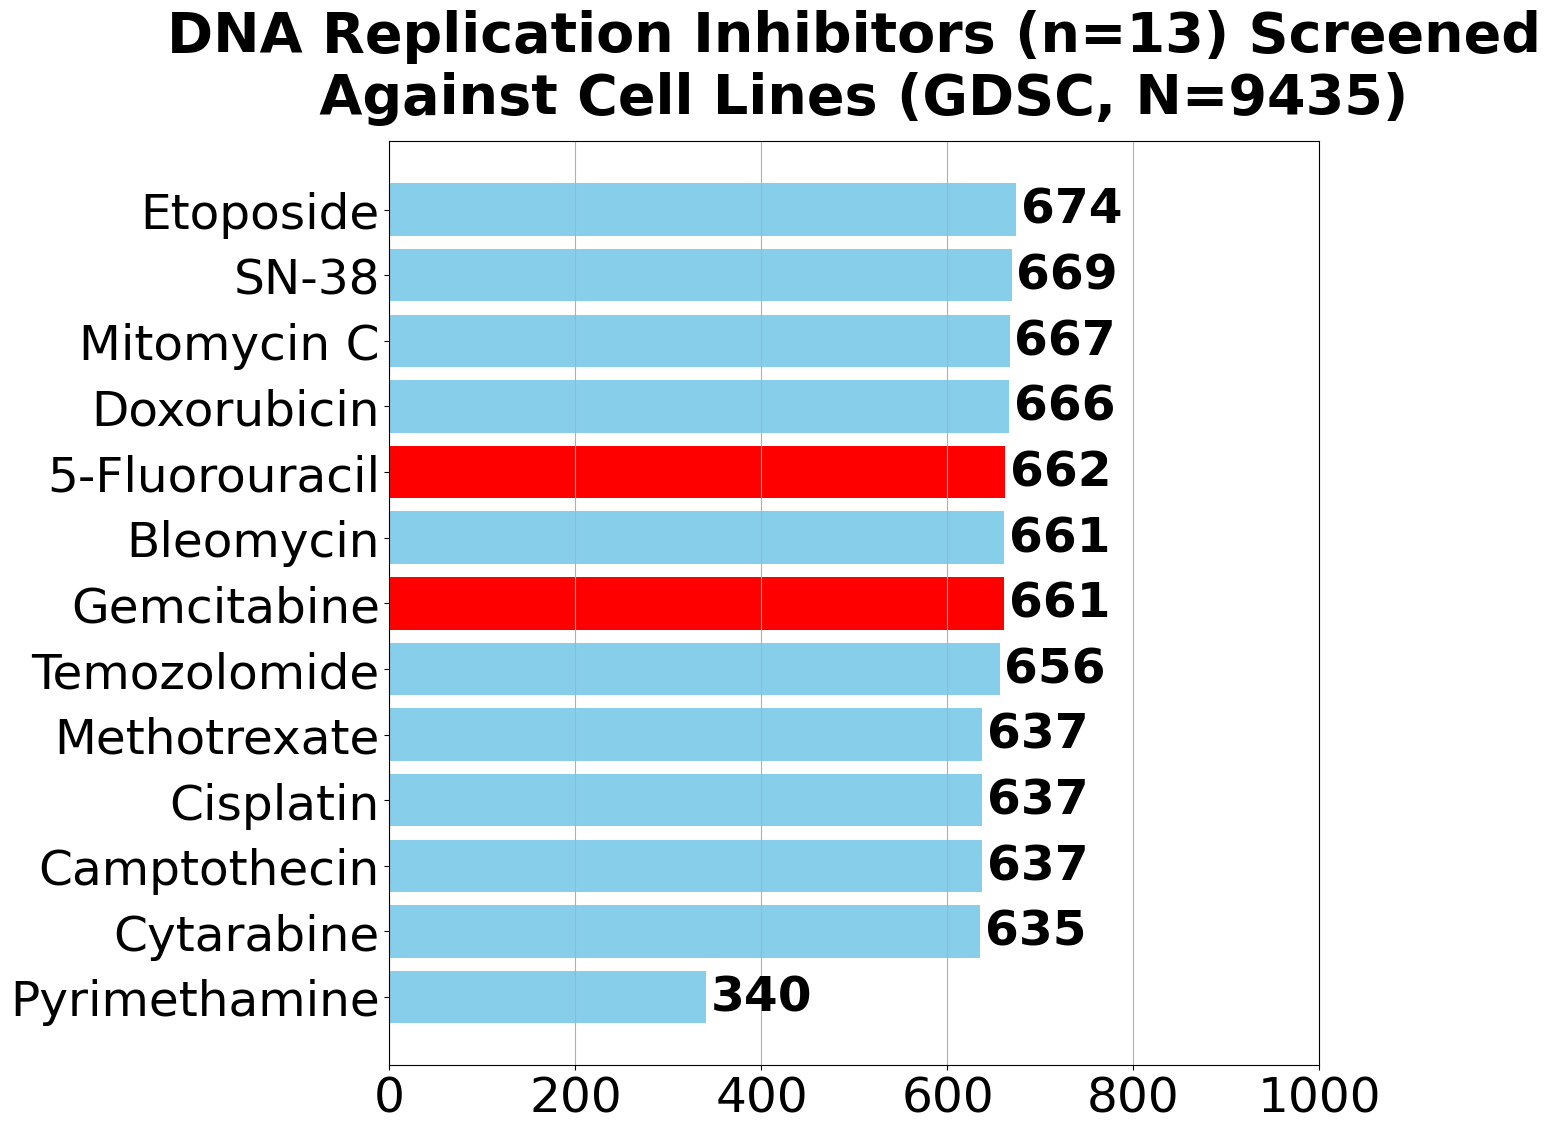

In [13]:
# PLOT DNA Replication İnhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

import os
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(12, 12))
bars = plt.barh(drug_names, drug_values, color='skyblue')

# Add text annotations
for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height() / 2, str(value), va='center', fontsize=35, fontweight="bold")

# Update bar colors for specific drug names
bars = []
for name, value in zip(drug_names, drug_values):
    if name == "5-Fluorouracil":
        bars.append(plt.barh(name, value, color='red'))
    elif name == "Gemcitabine":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

# Add labels, title, and grid
plt.xlabel(None)
plt.title(f'DNA Replication Inhibitors (n={len(drug_names)}) Screened\n Against Cell Lines (GDSC, N=9435)',
          fontweight='bold',
          fontsize=40,
          pad=20)
plt.xlim(0, 1000)
plt.grid(axis='x')
plt.tick_params(axis='y', labelsize=35)
plt.tick_params(axis='x', labelsize=35)

# Capture the figure object
fig_B = plt.gcf()  # Assign current figure to fig_B

# Save the figure
os.makedirs(save_figures_to, exist_ok = True)
fig_B.savefig(save_figures_to + 'DNA Replication Inhibitors with Their Counts (GDSC, 5-Fluorouracil).png',
              format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [14]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (5-Fluorouracil)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (5-Fluorouracil)

PDXEfluorouracil = pd.read_csv("PDX_exprs.5-Fluorouracil.eb_with.GDSC_exprs.5-Fluorouracil.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEfluorouracil = pd.DataFrame.transpose(PDXEfluorouracil)
PDXEfluorouracil.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1027,4.11649564280422,3.59209496158439,6.28559101273304,2.67926549063284,3.04621480878604,2.69044790660834,8.01420464403606,2.73140674359613,8.71768731731273,2.89488898093329,...,2.71033163066003,3.2543218456306,5.67560198356418,3.07143466694584,3.0597754133993,2.63635721806084,2.61292331163008,3.18623983789074,0,2.4522722382887
X-1119,4.00318976265845,3.59209496158439,7.55375516379688,4.03669966422185,3.41557516120483,5.94712898968845,8.14610109582064,2.54373640699005,7.8874359290969,3.43325748497387,...,2.80929358976047,3.3020335598854,8.94930072777643,3.07143466694584,3.0597754133993,2.63635721806084,2.61292331163008,4.60199637750889,0,2.89512503666773
X-1173,3.74198340066366,3.67493736139833,6.16750446793135,3.50545765081401,3.04295501121306,2.98779164904873,8.37697489020915,2.64942372799293,8.2967442081863,4.13640544224621,...,2.71033163066003,3.2543218456306,4.67270724878415,3.07143466694584,3.0597754133993,2.63635721806084,2.61292331163008,4.99706823903714,0,3.34491841640924


In [16]:
# read TCGA expression dataset homogenized with GDSC expression dataset (5-Fluorouracil)

TCGAEfluorouracil = pd.read_csv("TCGA_exprs.Fluorouracil.eb_with.GDSC_exprs.5-Fluorouracil.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEfluorouracil = pd.DataFrame.transpose(TCGAEfluorouracil)
TCGAEfluorouracil.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-3A-A9IC,5.72964960061116,4.41876362025309,4.86023990366878,2.47277876318537,4.81396331677419,2.6727941627861,8.72268461889477,2.5342747028707,8.30356599972612,2.66680810277045,...,9.61327758421809,2.69169602849574,2.74156299885291,3.14358416474115,3.63806017988108,2.83936659460498,2.84468471240513,2.9097524321588,4.74904572228446,4.63830114019886
TCGA-3A-A9IX,5.16820185705619,5.0656506669595,5.05015666335564,2.49748103264488,6.24486748738657,3.89184369807008,8.07246325142995,2.65471072107481,8.69196063245573,3.97461007293206,...,9.28039145658571,2.68523221938676,2.70770230320119,3.1831168236566,3.17601340812919,2.66266337139924,3.05740520413346,2.9097524321588,4.66674620630048,4.95684240309785
TCGA-AG-3593,4.09489404413517,3.56187701617794,5.74195136365074,3.52505514866919,0.688407410705727,2.04131612004455,8.50563761093224,2.83121226059543,8.98277420895832,4.7862922506412,...,9.44820752386781,3.3077275660044,3.04450667890368,3.53272687811095,2.90679846697165,2.45941479590968,2.65824917267036,2.9097524321588,5.80963066021836,4.86261821976041


In [17]:
# change directory to read PDX mutation dataset (5-Fluorouracil)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [18]:
# read PDX mutation dataset (5-Fluorouracil)

PDXMfluorouracil = pd.read_csv("PDX_mutations.5-Fluorouracil.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMfluorouracil.drop_duplicates(keep='last')
PDXMfluorouracil = pd.DataFrame.transpose(PDXMfluorouracil)
PDXMfluorouracil = PDXMfluorouracil.loc[:, ~PDXMfluorouracil.columns.duplicated()]

PDXMfluorouracil.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1119,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1173,0.0,0.0,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# read TCGA mutation dataset (5-Fluorouracil)

TCGAMfluorouracil = pd.read_csv("TCGA_mutations.Fluorouracil.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMfluorouracil.drop_duplicates(keep='last')
TCGAMfluorouracil = pd.DataFrame.transpose(TCGAMfluorouracil)
TCGAMfluorouracil = TCGAMfluorouracil.loc[:, ~TCGAMfluorouracil.columns.duplicated()]

TCGAMfluorouracil.head(3)

,9729,2050,515,140803,55814,51207,27143,152586,283659,51725,...,170393,401940,3249,254958,388199,55049,162699,114299,55969,147841
TCGA-3A-A9IC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-3A-A9IX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-AG-3593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# variance threshold for GDSC expression dataset (DNA_REPi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [21]:
# fill NA values and binarize GDSC mutation dataset (DNA_REPi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [22]:
# select shared genes between GDSC, PDX, and TCGA expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEfluorouracil.columns)
ls = ls.intersection(PDXMfluorouracil.columns)
ls = ls.intersection(TCGAEfluorouracil.columns)
ls = ls.intersection(TCGAMfluorouracil.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 13700


In [23]:
# select shared samples between GDSC expression, mutation, and response datasets (DNA_REPi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 694


In [24]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (694, 13700)
GDSC # of common samples and genes (Mutation): (694, 13700)
GDSC # of samples (Response): 8202


In [25]:
# select shared samples between PDX expression and mutation datasets (5-Fluorouracil) 

ls3 = PDXEfluorouracil.index.intersection(PDXMfluorouracil.index)

print(f"PDX # of common samples (5-Fluorouracil): {ls3.shape[0]}")

PDX # of common samples (5-Fluorouracil): 23


In [26]:
# select shared samples between TCGA expression and mutation datasets (5-Fluorouracil) 

ls4 = TCGAEfluorouracil.index.intersection(TCGAMfluorouracil.index)

print(f"TCGA # of common samples (5-Fluorouracil): {ls4.shape[0]}")

TCGA # of common samples (5-Fluorouracil): 33


In [27]:
# select shared genes and samples between PDX and TCGA expression and mutation datasets (5-Fluorouracil)

PDXEfluorouracil = PDXEfluorouracil.loc[ls3, ls]
PDXMfluorouracil = PDXMfluorouracil.loc[ls3, ls]

TCGAEfluorouracil = TCGAEfluorouracil.loc[ls4, ls]
TCGAMfluorouracil = TCGAMfluorouracil.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (5-Fluorouracil): {PDXEfluorouracil.shape}")
print(f"PDX # of common samples and genes for Mutation (5-Fluorouracil): {PDXMfluorouracil.shape}\n")

print(f"TCGA # of common samples and genes for Expression (5-Fluorouracil): {TCGAEfluorouracil.shape}")
print(f"TCGA # of common samples and genes for Mutation (5-Fluorouracil): {TCGAMfluorouracil.shape}")

PDX # of common samples and genes for Expression (5-Fluorouracil): (23, 13700)
PDX # of common samples and genes for Mutation (5-Fluorouracil): (23, 13700)

TCGA # of common samples and genes for Expression (5-Fluorouracil): (33, 13700)
TCGA # of common samples and genes for Mutation (5-Fluorouracil): (33, 13700)


In [28]:
# change directory to read DEGs (DNA_REPi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/DNA_REPi


In [29]:
# read DEGs (DNA_REPi)

DEGs_filtered_data = pd.read_excel("DNA_REPi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors\n")

DEGs_filtered_data.head()

There are 858 DEGs (p-adjusted < 0.05 and |logFC| > 1) among DNA replication inhibitors



,Gene Symbol,Frequency
0,SLFN11,9
1,NCKAP1L,8
2,SDC4,7
3,KRT18,7
4,S100A14,7


In [30]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id.dropna(inplace=True)

DEGs_entrez_id.shape[0]

1 input query terms found dup hits:	[('CLECL1P', 2)]


858

In [31]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [32]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
906794,0,3.25484543425934,Pyrimethamine,1,1,1
906794,0,-3.08563930086988,Doxorubicin,1,1,1
906794,1,-2.64209579180854,Etoposide,1,1,1


In [33]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'5-Fluorouracil',
 'Bleomycin',
 'Camptothecin',
 'Cisplatin',
 'Cytarabine',
 'Doxorubicin',
 'Etoposide',
 'Gemcitabine',
 'Methotrexate',
 'Mitomycin C',
 'Pyrimethamine',
 'SN-38',
 'Temozolomide'}

In [34]:
# convert Entrez gene IDs to integer

GDSCE.index = GDSCE.index.astype(str)
GDSCM.index = GDSCM.index.astype(str)
responses.index = responses.index.astype(str)

In [35]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
lung_NSCLC           1037
urogenital_system     926
leukemia              829
lymphoma              769
nervous_system        607
lung_SCLC             569
skin                  560
breast                524
aero_dig_tract        451
bone                  421
neuroblastoma         332
digestive_system      250
kidney                227
soft_tissue           191
myeloma               182
lung                  174
thyroid               153
Name: count, dtype: int64

In [36]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    639
lung_small_cell_carcinoma    569
glioma                       558
breast                       524
melanoma                     522
Name: count, dtype: int64

In [37]:
# assign tissue descriptors to variable

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names

['lung_NSCLC',
 'urogenital_system',
 'leukemia',
 'lymphoma',
 'nervous_system',
 'lung_SCLC',
 'skin',
 'breast',
 'aero_dig_tract',
 'bone',
 'neuroblastoma',
 'digestive_system',
 'kidney',
 'soft_tissue',
 'myeloma',
 'lung',
 'thyroid']

In [38]:
# list count of cell lines as to tissues treated with fluorouracil

filter = (dat["drug"] == "5-Fluorouracil")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
lung_NSCLC           86
urogenital_system    78
leukemia             63
lymphoma             57
nervous_system       50
skin                 47
lung_SCLC            46
breast               44
aero_dig_tract       36
bone                 34
neuroblastoma        28
digestive_system     21
kidney               18
lung                 15
soft_tissue          14
myeloma              13
thyroid              12
Name: count, dtype: int64

In [39]:
# list count of cell lines as to tissues treated with fluorouracil

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "5-Fluorouracil")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    53
glioma                       46
lung_small_cell_carcinoma    46
melanoma                     44
breast                       44
Name: count, dtype: int64

In [40]:
# filter GDSC expression and mutation datasets (DNA_REPi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEfluorouracil = PDXEfluorouracil.loc[:,ls5]
PDXMfluorouracil = PDXMfluorouracil.loc[:,ls5]
TCGAEfluorouracil = TCGAEfluorouracil.loc[:,ls5]
TCGAMfluorouracil = TCGAMfluorouracil.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for 5-Fluorouracil (Expression): {PDXEfluorouracil.shape}")
print(f"PDX # of common samples and genes for 5-Fluorouracil (Mutation): {PDXMfluorouracil.shape}\n")

print(f"TCGA # of common samples and genes for 5-Fluorouracil (Expression): {TCGAEfluorouracil.shape}")
print(f"TCGA # of common samples and genes for 5-Fluorouracil (Mutation): {TCGAMfluorouracil.shape}")

GDSC # of common samples and genes (Expression): (8202, 699)
GDSC # of common samples and genes (Mutation): (8202, 699)
GDSC # of common samples (Response): 8202

PDX # of common samples and genes for 5-Fluorouracil (Expression): (23, 699)
PDX # of common samples and genes for 5-Fluorouracil (Mutation): (23, 699)

TCGA # of common samples and genes for 5-Fluorouracil (Expression): (33, 699)
TCGA # of common samples and genes for 5-Fluorouracil (Mutation): (33, 699)


In [41]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 1 ... 0 0 1]


In [42]:
# change directory to read PDX and TCGA response datasets (5-Fluorouracil)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [43]:
# read PDX response dataset (5-Fluorouracil)

PDXRfluorouracil = pd.read_csv("PDX_response.5-Fluorouracil.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRfluorouracil.dropna(inplace=True)
PDXRfluorouracil.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRfluorouracil["response"] = PDXRfluorouracil.loc[:, "response"].apply(lambda x: d[x])
Ytsfluorouracil_pdx = PDXRfluorouracil["response"].values    

print(f"There are {Ytsfluorouracil_pdx.shape[0]} samples with response data in the PDX (5-Fluorouracil)\n")
Ytsfluorouracil_pdx

There are 23 samples with response data in the PDX (5-Fluorouracil)



array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [44]:
# read PDX dataset to select cohorts (5-Fluorouracil)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "5FU",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-0933,CRC
X-1027,CRC
X-1055,CRC
X-1119,CRC
X-1167,CRC


In [45]:
# merged PDX cohort table with PDX response dataset (5-Fluorouracil)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRfluorouracil,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
CRC    23
Name: count, dtype: int64

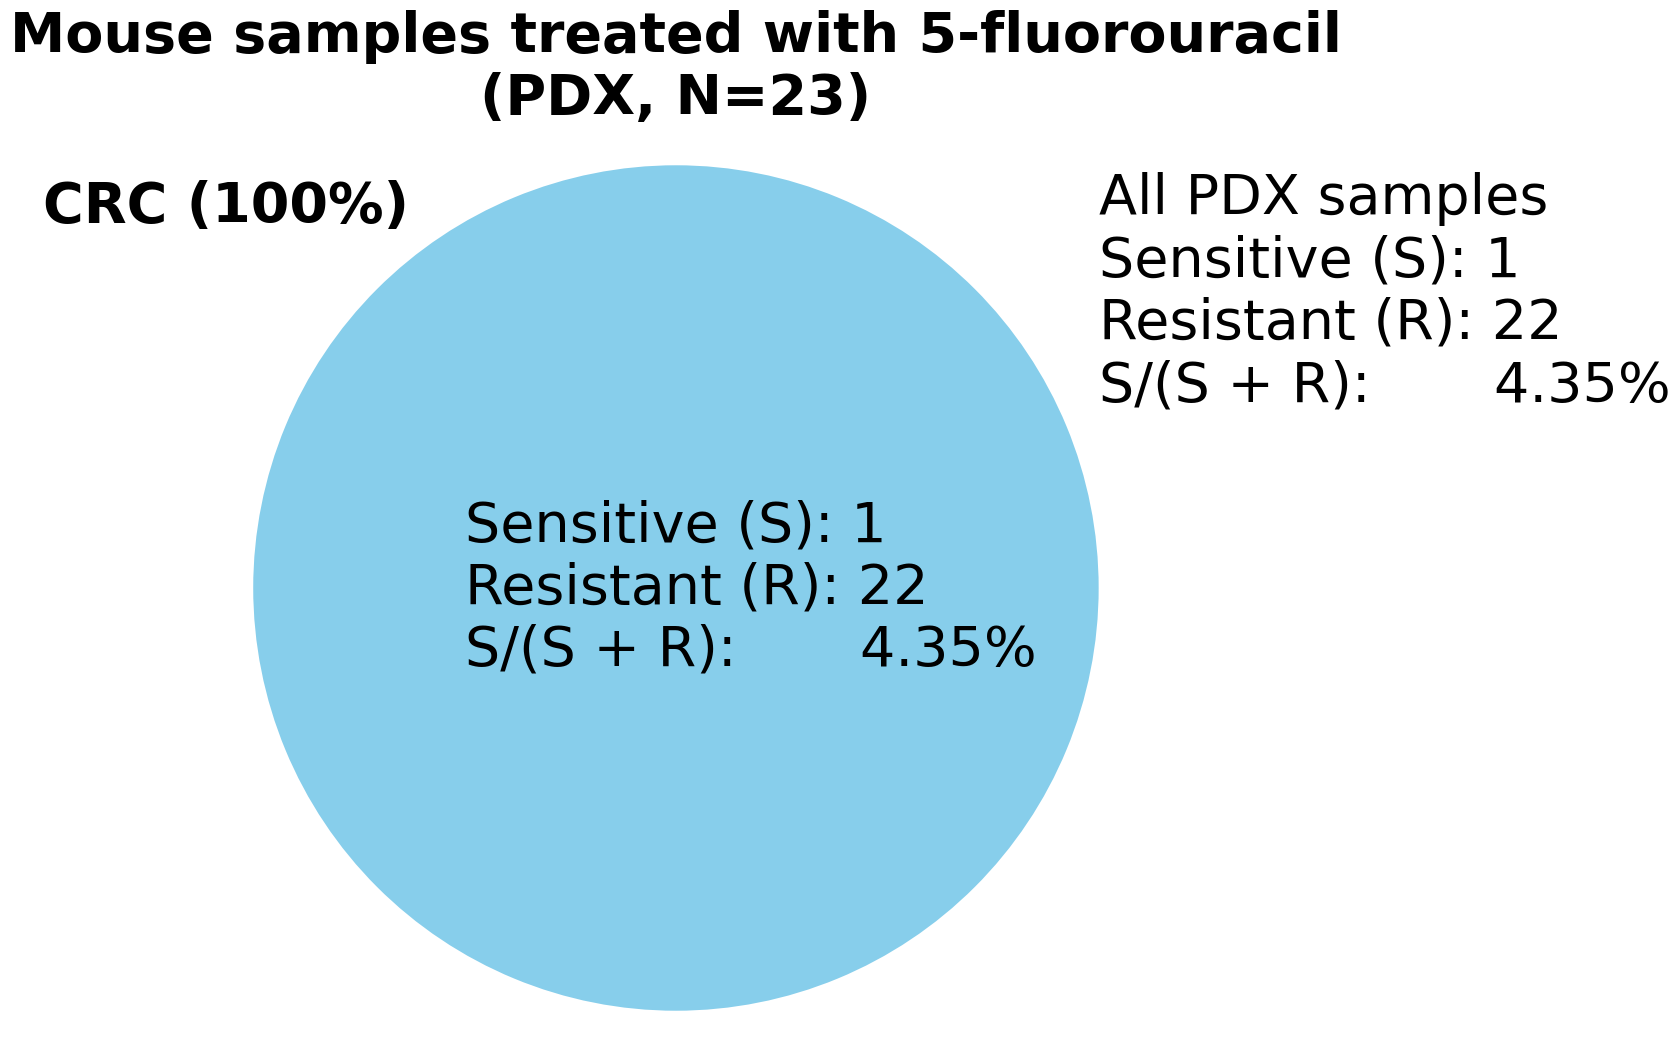

In [46]:
# plot tissue types of PDX samples

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

os.makedirs(save_figures_to, exist_ok=True)

# Create the figure
plt.figure(figsize=(12, 12))
plt.pie(
    sizes, 
    labels=labels_with_percentages, 
    startangle=-55, 
    colors=['skyblue'], 
    textprops={'fontsize': 40, 'fontweight': 'bold'}
)
plt.title(f'Mouse samples treated with 5-fluorouracil\n(PDX, N={total})', fontweight="bold", fontsize=40)
plt.axis('equal')

# Add summary text
plt.text(
    -0.5, 0,
    f'Sensitive (S): {PDXRfluorouracil["response"].value_counts()[1]} \n'
    f'Resistant (R): {PDXRfluorouracil["response"].value_counts()[0]} \n'
    f'S/(S + R):       {round(PDXRfluorouracil["response"].value_counts()[1] / (sum(PDXRfluorouracil["response"].value_counts())) * 100, 2)}%',
    fontsize=40,
    color='black',
    va='center'
)

plt.text(
    1, 0.7,
    f'All PDX samples\nSensitive (S): {PDXRfluorouracil["response"].value_counts()[1]} \n'
    f'Resistant (R): {PDXRfluorouracil["response"].value_counts().get(0, 0)} \n'
    f'S/(S + R):       {round(PDXRfluorouracil["response"].value_counts()[1] / (sum(PDXRfluorouracil["response"].value_counts())) * 100, 2)}%',
    fontsize=40,
    color='black',
    va='center'
)

# Capture the figure object
fig_E = plt.gcf()  # Assign current figure to fig_E

# Save the figure
fig_E.savefig(save_figures_to + 'Tissue_types_of_PDX_samples_5_Fluorouracil.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [47]:
# filter CRC cohort samples (5-Fluorouracil)

filter = (dat_pdx["Tumor Type"] == "CRC")
pdx_crc_samples = dat_pdx.loc[filter,].index
pdx_crc_samples

Index(['X-1027', 'X-1119', 'X-1173', 'X-1270', 'X-1329', 'X-2145', 'X-2182',
       'X-2483', 'X-2538', 'X-2573', 'X-2659', 'X-2846', 'X-2861', 'X-3093',
       'X-3205', 'X-3267', 'X-3671', 'X-3792', 'X-4087', 'X-5405', 'X-5438',
       'X-5495', 'X-5578'],
      dtype='object')

In [48]:
# filter responses of CRC cohort samples (5-Fluorouracil)

Ytsfluorouracil_pdx_crc = PDXRfluorouracil.loc[pdx_crc_samples,"response"].values
Ytsfluorouracil_pdx_crc

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [49]:
# count of sensitive and resistant CRC samples (5-Fluorouracil)

PDXRfluorouracil.loc[pdx_crc_samples,"response"].value_counts()

response
0    22
1     1
Name: count, dtype: int64

In [50]:
# read TCGA response dataset (5-Fluorouracil)

TCGARfluorouracil = pd.read_csv("TCGA_response.Fluorouracil.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARfluorouracil.dropna(inplace=True)
TCGARfluorouracil.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARfluorouracil["response"] = TCGARfluorouracil.loc[:, "response"].apply(lambda x: d[x])
Ytsfluorouracil_tcga = TCGARfluorouracil["response"].values    

print(f"There are {Ytsfluorouracil_tcga.shape[0]} samples with response data in the TCGA (5-Fluorouracil)\n")
Ytsfluorouracil_tcga

There are 33 samples with response data in the TCGA (5-Fluorouracil)



array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1])

In [51]:
# TCGA cohort table with TCGA response dataset (5-Fluorouracil)

dat_tcga = TCGARfluorouracil["cohort"]

dat_tcga.value_counts()

cohort
STAD    18
READ     7
PAAD     6
ESCA     2
Name: count, dtype: int64

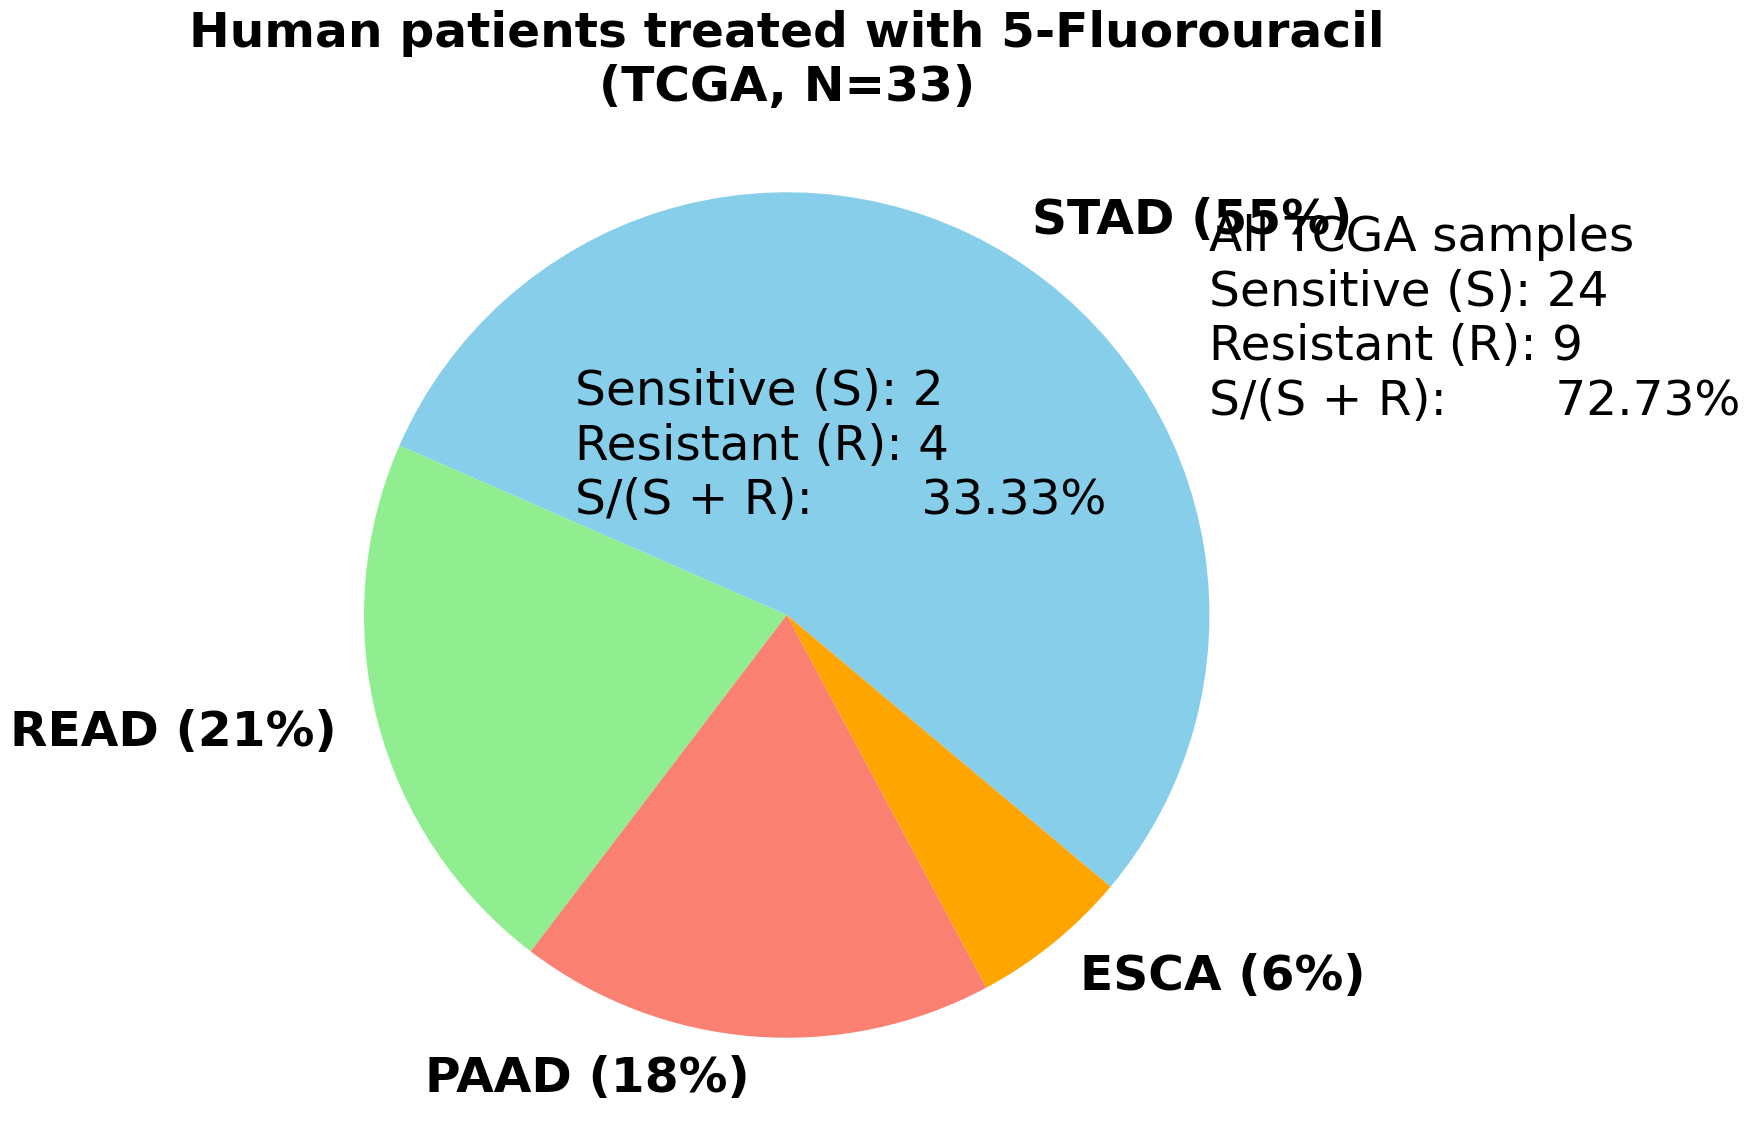

In [52]:
# plot tissue types of TCGA samples

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

# Create the figure
plt.figure(figsize=(12, 12))
plt.pie(
    sizes,
    labels=labels_with_percentages,
    startangle=-40,
    colors=['skyblue', 'lightgreen', 'salmon', 'orange', 'pink'],
    textprops={'fontsize': 35, 'fontweight': 'bold'}
)
plt.title(f'Human patients treated with 5-Fluorouracil\n(TCGA, N={total})', fontweight="bold", fontsize=35)
plt.subplots_adjust(top=0.95)
plt.axis('equal')

# Add summary text for PAAD cohort
plt.text(
    -0.5, 0.4,
    f'Sensitive (S): {TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts()[1]} \n'
    f'Resistant (R): {TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts()[0]} \n'
    f'S/(S + R):       {round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts()[1] / (sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD", "response"].value_counts())) * 100, 2)}%',
    fontsize=35,
    color='black',
    va='center'
)

# Add summary text for all TCGA samples
plt.text(
    1, 0.7,
    f'All TCGA samples\nSensitive (S): {TCGARfluorouracil["response"].value_counts()[1]} \n'
    f'Resistant (R): {TCGARfluorouracil["response"].value_counts().get(0, 0)} \n'
    f'S/(S + R):       {round(TCGARfluorouracil["response"].value_counts()[1] / (sum(TCGARfluorouracil["response"].value_counts())) * 100, 2)}%',
    fontsize=35,
    color='black',
    va='center'
)

# Capture the figure object
fig_H = plt.gcf()  # Assign current figure to fig_H

# Save the figure
fig_H.savefig(save_figures_to + 'Tissue_types_of_TCGA_samples_Fluorouracil.png', format='png', bbox_inches='tight')

# Show the plot
plt.show()

In [53]:
# filter STAD cohort samples (5-Fluorouracil)

filter = (TCGARfluorouracil["cohort"] == "STAD")
tcga_stad_samples = dat_tcga.loc[filter,].index
tcga_stad_samples

Index(['TCGA-CG-4444', 'TCGA-D7-8579', 'TCGA-D7-A748', 'TCGA-F1-A448',
       'TCGA-FP-7829', 'TCGA-FP-8209', 'TCGA-HU-8243', 'TCGA-KB-A6F7',
       'TCGA-VQ-A8DT', 'TCGA-VQ-A8DU', 'TCGA-VQ-A8DZ', 'TCGA-VQ-A8E2',
       'TCGA-VQ-A8P3', 'TCGA-VQ-A91Q', 'TCGA-VQ-AA68', 'TCGA-VQ-AA6B',
       'TCGA-VQ-AA6F', 'TCGA-VQ-AA6G'],
      dtype='object')

In [54]:
# filter responses of STAD cohort samples (5-Fluorouracil)

Ytsfluorouracil_tcga_stad = TCGARfluorouracil.loc[tcga_stad_samples,"response"].values
Ytsfluorouracil_tcga_stad

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0])

In [55]:
# count of sensitive and resistance STAD samples (5-Fluorouracil)

TCGARfluorouracil.loc[tcga_stad_samples,"response"].value_counts()

response
1    13
0     5
Name: count, dtype: int64

In [56]:
# filter PAAD cohort samples (5-Fluorouracil)

filter = (TCGARfluorouracil["cohort"] == "PAAD")
tcga_paad_samples = dat_tcga.loc[filter,].index
tcga_paad_samples

Index(['TCGA-3A-A9IC', 'TCGA-3A-A9IX', 'TCGA-HZ-7920', 'TCGA-HZ-A49I',
       'TCGA-IB-7888', 'TCGA-OE-A75W'],
      dtype='object')

In [57]:
# filter responses of PAAD cohort samples (5-Fluorouracil)

Ytsfluorouracil_tcga_paad = TCGARfluorouracil.loc[tcga_paad_samples,"response"].values
Ytsfluorouracil_tcga_paad

array([0, 1, 1, 0, 0, 0])

In [58]:
# count of sensitive and resistance _paad samples (5-Fluorouracil)

TCGARfluorouracil.loc[tcga_paad_samples,"response"].value_counts()

response
0    4
1    2
Name: count, dtype: int64

In [59]:
# maximum iteration

max_iter = 50

In [73]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 16
hdm2 = 16
rate1 = 0.4
rate2 = 0.3
rate3 = 0.3

In [74]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEfluorouracil_pdx = scalerGDSC.transform(PDXEfluorouracil.values) 
X_testEfluorouracil_pdx_crc = scalerGDSC.transform(PDXEfluorouracil.loc[pdx_crc_samples,].values) 

X_testEfluorouracil_tcga = scalerGDSC.transform(TCGAEfluorouracil.values)    
X_testEfluorouracil_tcga_stad = scalerGDSC.transform(TCGAEfluorouracil.loc[tcga_stad_samples,].values)    
X_testEfluorouracil_tcga_paad = scalerGDSC.transform(TCGAEfluorouracil.loc[tcga_paad_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMfluorouracil_pdx = np.nan_to_num(PDXMfluorouracil.values.astype(np.float32))
X_testMfluorouracil_pdx_crc = np.nan_to_num(PDXMfluorouracil.loc[pdx_crc_samples,].values.astype(np.float32))
X_testMfluorouracil_tcga = np.nan_to_num(TCGAMfluorouracil.values.astype(np.float32))
X_testMfluorouracil_tcga_stad = np.nan_to_num(TCGAMfluorouracil.loc[tcga_stad_samples,].values.astype(np.float32))
X_testMfluorouracil_tcga_paad = np.nan_to_num(TCGAMfluorouracil.loc[tcga_paad_samples,].values.astype(np.float32))

TX_testEfluorouracil_pdx = torch.FloatTensor(X_testEfluorouracil_pdx)
TX_testEfluorouracil_pdx_crc = torch.FloatTensor(X_testEfluorouracil_pdx_crc)

TX_testMfluorouracil_pdx = torch.FloatTensor(X_testMfluorouracil_pdx.astype(np.float32))
TX_testMfluorouracil_pdx_crc = torch.FloatTensor(X_testMfluorouracil_pdx_crc.astype(np.float32))

ty_testEfluorouracil_pdx = torch.FloatTensor(Ytsfluorouracil_pdx.astype(int))
ty_testEfluorouracil_pdx_crc = torch.FloatTensor(Ytsfluorouracil_pdx_crc.astype(int))

TX_testEfluorouracil_tcga = torch.FloatTensor(X_testEfluorouracil_tcga)
TX_testEfluorouracil_tcga_stad = torch.FloatTensor(X_testEfluorouracil_tcga_stad)
TX_testEfluorouracil_tcga_paad = torch.FloatTensor(X_testEfluorouracil_tcga_paad)

TX_testMfluorouracil_tcga = torch.FloatTensor(X_testMfluorouracil_tcga.astype(np.float32))
TX_testMfluorouracil_tcga_stad = torch.FloatTensor(X_testMfluorouracil_tcga_stad.astype(np.float32))
TX_testMfluorouracil_tcga_paad = torch.FloatTensor(X_testMfluorouracil_tcga_paad.astype(np.float32))

ty_testEfluorouracil_tcga = torch.FloatTensor(Ytsfluorouracil_tcga.astype(int))
ty_testEfluorouracil_tcga_stad = torch.FloatTensor(Ytsfluorouracil_tcga_stad.astype(int))
ty_testEfluorouracil_tcga_paad = torch.FloatTensor(Ytsfluorouracil_tcga_paad.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy.pt")
AutoencoderM = torch.load(models_dir + "Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy.pt")

Clas = torch.load(models_dir + "Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())

ZETfluorouracil_pdx = AutoencoderE(TX_testEfluorouracil_pdx)
ZMTfluorouracil_pdx = AutoencoderM(TX_testMfluorouracil_pdx)
ZTTfluorouracil_pdx = torch.cat((ZETfluorouracil_pdx, ZMTfluorouracil_pdx), 1)
ZTTfluorouracil_pdx = F.normalize(ZTTfluorouracil_pdx, p=2, dim=0)
PredTfluorouracil_pdx = Clas(ZTTfluorouracil_pdx)
AUCTfluorouracil_pdx = roc_auc_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())
AUCTfluorouracil_pdx_aucpr = average_precision_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())

ZETfluorouracil_pdx_crc = AutoencoderE(TX_testEfluorouracil_pdx_crc)
ZMTfluorouracil_pdx_crc = AutoencoderM(TX_testMfluorouracil_pdx_crc)
ZTTfluorouracil_pdx_crc = torch.cat((ZETfluorouracil_pdx_crc, ZMTfluorouracil_pdx_crc), 1)
ZTTfluorouracil_pdx_crc = F.normalize(ZTTfluorouracil_pdx_crc, p=2, dim=0)
PredTfluorouracil_pdx_crc = Clas(ZTTfluorouracil_pdx_crc)
AUCTfluorouracil_pdx_crc = roc_auc_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())
AUCTfluorouracil_pdx_crc_aucpr = average_precision_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())

ZETfluorouracil_tcga = AutoencoderE(TX_testEfluorouracil_tcga)
ZMTfluorouracil_tcga = AutoencoderM(TX_testMfluorouracil_tcga)
ZTTfluorouracil_tcga = torch.cat((ZETfluorouracil_tcga, ZMTfluorouracil_tcga), 1)
ZTTfluorouracil_tcga = F.normalize(ZTTfluorouracil_tcga, p=2, dim=0)
PredTfluorouracil_tcga = Clas(ZTTfluorouracil_tcga)
AUCTfluorouracil_tcga = roc_auc_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())
AUCTfluorouracil_tcga_aucpr = average_precision_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())

ZETfluorouracil_tcga_stad = AutoencoderE(TX_testEfluorouracil_tcga_stad)
ZMTfluorouracil_tcga_stad = AutoencoderM(TX_testMfluorouracil_tcga_stad)
ZTTfluorouracil_tcga_stad = torch.cat((ZETfluorouracil_tcga_stad, ZMTfluorouracil_tcga_stad), 1)
ZTTfluorouracil_tcga_stad = F.normalize(ZTTfluorouracil_tcga_stad, p=2, dim=0)
PredTfluorouracil_tcga_stad = Clas(ZTTfluorouracil_tcga_stad)
AUCTfluorouracil_tcga_stad = roc_auc_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())
AUCTfluorouracil_tcga_stad_aucpr = average_precision_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())

ZETfluorouracil_tcga_paad = AutoencoderE(TX_testEfluorouracil_tcga_paad)
ZMTfluorouracil_tcga_paad = AutoencoderM(TX_testMfluorouracil_tcga_paad)
ZTTfluorouracil_tcga_paad = torch.cat((ZETfluorouracil_tcga_paad, ZMTfluorouracil_tcga_paad), 1)
ZTTfluorouracil_tcga_paad = F.normalize(ZTTfluorouracil_tcga_paad, p=2, dim=0)
PredTfluorouracil_tcga_paad = Clas(ZTTfluorouracil_tcga_paad)
AUCTfluorouracil_tcga_paad = roc_auc_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())
AUCTfluorouracil_tcga_paad_aucpr = average_precision_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTfluorouracil_pdx_finetuned = dict()
AUCTfluorouracil_tcga_finetuned = dict()
AUCTfluorouracil_pdx_crc_finetuned = dict()
AUCTfluorouracil_tcga_stad_finetuned = dict()
AUCTfluorouracil_tcga_paad_finetuned = dict()
AUCTfluorouracil_pdx_aucpr_finetuned = dict()
AUCTfluorouracil_tcga_aucpr_finetuned = dict()
AUCTfluorouracil_pdx_crc_aucpr_finetuned = dict()
AUCTfluorouracil_tcga_stad_aucpr_finetuned = dict()
AUCTfluorouracil_tcga_paad_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(finetuned_dir + f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(finetuned_dir + f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZTX = torch.cat((ZEX, ZMX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETfluorouracil_pdx = AutoencoderE_finetuned(TX_testEfluorouracil_pdx)
   ZMTfluorouracil_pdx = AutoencoderM_finetuned(TX_testMfluorouracil_pdx)
   ZTTfluorouracil_pdx = torch.cat((ZETfluorouracil_pdx, ZMTfluorouracil_pdx), 1)
   ZTTfluorouracil_pdx = F.normalize(ZTTfluorouracil_pdx, p=2, dim=0)
   PredTfluorouracil_pdx = Clas_finetuned(ZTTfluorouracil_pdx)
   AUCTfluorouracil_pdx_finetuned[iter] = roc_auc_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())
   AUCTfluorouracil_pdx_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_pdx.astype(int), PredTfluorouracil_pdx.detach().numpy())

   ZETfluorouracil_pdx_crc = AutoencoderE_finetuned(TX_testEfluorouracil_pdx_crc)
   ZMTfluorouracil_pdx_crc = AutoencoderM_finetuned(TX_testMfluorouracil_pdx_crc)
   ZTTfluorouracil_pdx_crc = torch.cat((ZETfluorouracil_pdx_crc, ZMTfluorouracil_pdx_crc), 1)
   ZTTfluorouracil_pdx_crc = F.normalize(ZTTfluorouracil_pdx_crc, p=2, dim=0)
   PredTfluorouracil_pdx_crc = Clas_finetuned(ZTTfluorouracil_pdx_crc)
   AUCTfluorouracil_pdx_crc_finetuned[iter] = roc_auc_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())
   AUCTfluorouracil_pdx_crc_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_pdx_crc.astype(int), PredTfluorouracil_pdx_crc.detach().numpy())

   ZETfluorouracil_tcga = AutoencoderE_finetuned(TX_testEfluorouracil_tcga)
   ZMTfluorouracil_tcga = AutoencoderM_finetuned(TX_testMfluorouracil_tcga)
   ZTTfluorouracil_tcga = torch.cat((ZETfluorouracil_tcga, ZMTfluorouracil_tcga), 1)
   ZTTfluorouracil_tcga = F.normalize(ZTTfluorouracil_tcga, p=2, dim=0)
   PredTfluorouracil_tcga = Clas_finetuned(ZTTfluorouracil_tcga)
   AUCTfluorouracil_tcga_finetuned[iter] = roc_auc_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())
   AUCTfluorouracil_tcga_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_tcga.astype(int), PredTfluorouracil_tcga.detach().numpy())

   ZETfluorouracil_tcga_stad = AutoencoderE_finetuned(TX_testEfluorouracil_tcga_stad)
   ZMTfluorouracil_tcga_stad = AutoencoderM_finetuned(TX_testMfluorouracil_tcga_stad)
   ZTTfluorouracil_tcga_stad = torch.cat((ZETfluorouracil_tcga_stad, ZMTfluorouracil_tcga_stad), 1)
   ZTTfluorouracil_tcga_stad = F.normalize(ZTTfluorouracil_tcga_stad, p=2, dim=0)
   PredTfluorouracil_tcga_stad = Clas_finetuned(ZTTfluorouracil_tcga_stad)
   AUCTfluorouracil_tcga_stad_finetuned[iter] = roc_auc_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())
   AUCTfluorouracil_tcga_stad_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_tcga_stad.astype(int), PredTfluorouracil_tcga_stad.detach().numpy())
    
   ZETfluorouracil_tcga_paad = AutoencoderE_finetuned(TX_testEfluorouracil_tcga_paad)
   ZMTfluorouracil_tcga_paad = AutoencoderM_finetuned(TX_testMfluorouracil_tcga_paad)
   ZTTfluorouracil_tcga_paad = torch.cat((ZETfluorouracil_tcga_paad, ZMTfluorouracil_tcga_paad), 1)
   ZTTfluorouracil_tcga_paad = F.normalize(ZTTfluorouracil_tcga_paad, p=2, dim=0)
   PredTfluorouracil_tcga_paad = Clas_finetuned(ZTTfluorouracil_tcga_paad)
   AUCTfluorouracil_tcga_paad_finetuned[iter] = roc_auc_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())
   AUCTfluorouracil_tcga_paad_aucpr_finetuned[iter] = average_precision_score(Ytsfluorouracil_tcga_paad.astype(int), PredTfluorouracil_tcga_paad.detach().numpy())

max_key_pdx = max(AUCTfluorouracil_pdx_aucpr_finetuned, key=AUCTfluorouracil_pdx_aucpr_finetuned.get)
max_key_pdx_crc = max(AUCTfluorouracil_pdx_crc_aucpr_finetuned, key=AUCTfluorouracil_pdx_crc_aucpr_finetuned.get)
max_key_tcga = max(AUCTfluorouracil_tcga_aucpr_finetuned, key=AUCTfluorouracil_tcga_aucpr_finetuned.get)
max_key_tcga_stad = max(AUCTfluorouracil_tcga_stad_aucpr_finetuned, key=AUCTfluorouracil_tcga_stad_aucpr_finetuned.get)
max_key_tcga_paad = max(AUCTfluorouracil_tcga_paad_aucpr_finetuned, key=AUCTfluorouracil_tcga_paad_aucpr_finetuned.get)

print(f"GDSC - Training AUC (DNA_REPi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (DNA_REPi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (5-Fluorouracil): {round(AUCTfluorouracil_pdx,2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_pdx_aucpr,2)}")
print(f"PDX - Test AUC (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc,2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc_aucpr,2)}")
print(f"TCGA - Test AUC (5-Fluorouracil): {round(AUCTfluorouracil_tcga,2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad,2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad_aucpr,2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad,2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad_aucpr,2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_pdx_crc],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUC (5-Fluorouracil, CRC, Finetuned): {round(AUCTfluorouracil_pdx_crc_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUCPR (5-Fluorouracil, CRC, Finetuned): {round(AUCTfluorouracil_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, Finetuned): {round(AUCTfluorouracil_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga_stad],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_stad],2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, STAD, Finetuned): {round(AUCTfluorouracil_tcga_stad_finetuned[max_key_tcga_stad],2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, STAD, Finetuned): {round(AUCTfluorouracil_tcga_stad_aucpr_finetuned[max_key_tcga_stad],2)}\n")

print(f"GDSC - Training AUC (DNA_REPi, Finetuned): {round(AUCT_finetuned[max_key_tcga_paad],2)}")
print(f"GDSC - Training AUCPR (DNA_REPi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUC (5-Fluorouracil, PAAD, Finetuned): {round(AUCTfluorouracil_tcga_paad_finetuned[max_key_tcga_paad],2)}")
print(f"TCGA - Test AUCPR (5-Fluorouracil, PAAD, Finetuned): {round(AUCTfluorouracil_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)}\n\n")

print("Models for maximum finetuning (5-Fluorouracil, PDX)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, PDX, CRC)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_crc}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, TCGA)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, TCGA, STAD)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Finetuned_{max_key_tcga_stad}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Finetuned_{max_key_tcga_stad}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Finetuned_{max_key_tcga_stad}.pt")

print("\nModels for maximum finetuning (5-Fluorouracil, TCGA, PAAD)")
print(f"Exprs_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Mut_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga_paad}.pt")
print(f"Class_Fluorouracil_GDSC_PDX_TCGA_DNA_REPi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga_paad}.pt")


GDSC - Training AUC (DNA_REPi): 0.82
GDSC - Training AUCPR (DNA_REPi): 0.33
PDX - Test AUC (5-Fluorouracil): 0.05
PDX - Test AUCPR (5-Fluorouracil): 0.05
PDX - Test AUC (5-Fluorouracil, CRC): 0.05
PDX - Test AUCPR (5-Fluorouracil, CRC): 0.05
TCGA - Test AUC (5-Fluorouracil): 0.84
TCGA - Test AUCPR (5-Fluorouracil): 0.93
TCGA - Test AUC (5-Fluorouracil, STAD): 0.86
TCGA - Test AUCPR (5-Fluorouracil, STAD): 0.95
TCGA - Test AUC (5-Fluorouracil, PAAD): 1.0
TCGA - Test AUCPR (5-Fluorouracil, PAAD): 1.0

GDSC - Training AUC (DNA_REPi, Finetuned): 0.82
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.34
PDX - Test AUC (5-Fluorouracil, Finetuned): 0.59
PDX - Test AUCPR (5-Fluorouracil, Finetuned): 0.1

GDSC - Training AUC (DNA_REPi, Finetuned): 0.82
GDSC - Training AUCPR (DNA_REPi, Finetuned): 0.34
PDX - Test AUC (5-Fluorouracil, CRC, Finetuned): 0.59
PDX - Test AUCPR (5-Fluorouracil, CRC, Finetuned): 0.1

GDSC - Training AUC (DNA_REPi, Finetuned): 0.81
GDSC - Training AUCPR (DNA_REPi, Finetune

In [62]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=699, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [63]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=699, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [64]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Sigmoid()
  )
)

In [65]:
# create a dataframe with the prediction results 

em  = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTfluorouracil_pdx,2), round(AUCTfluorouracil_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTfluorouracil_pdx_aucpr,2), round(AUCTfluorouracil_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-CRC)":  [round(AUCTfluorouracil_pdx_crc,2), round(AUCTfluorouracil_pdx_crc_finetuned[max_key_pdx_crc],2)],
       "AUCPR (PDX-CRC)": [round(AUCTfluorouracil_pdx_crc_aucpr,2), round(AUCTfluorouracil_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)],
       "AUC (TCGA)": [round(AUCTfluorouracil_tcga,2), round(AUCTfluorouracil_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTfluorouracil_tcga_aucpr,2), round(AUCTfluorouracil_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-STAD)":  [round(AUCTfluorouracil_tcga_stad,2), round(AUCTfluorouracil_tcga_stad_finetuned[max_key_tcga_stad],2)],
       "AUCPR (TCGA-STAD)": [round(AUCTfluorouracil_tcga_stad_aucpr,2), round(AUCTfluorouracil_tcga_stad_aucpr_finetuned[max_key_tcga_stad],2)],
       "AUC (TCGA-PAAD)":  [round(AUCTfluorouracil_tcga_paad,2), round(AUCTfluorouracil_tcga_paad_finetuned[max_key_tcga_paad],2)],
       "AUCPR (TCGA-PAAD)": [round(AUCTfluorouracil_tcga_paad_aucpr,2), round(AUCTfluorouracil_tcga_paad_aucpr_finetuned[max_key_tcga_paad],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
em_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_DNA_REPi_Fluorouracil_Third_Strategy.tsv",
                     sep = "\t",
                     index = False)

em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytsfluorouracil_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytsfluorouracil_pdx)) + ")",
    "AUC (PDX-CRC)": "AUC (PDX-CRC, N=" + str(len(Ytsfluorouracil_pdx_crc)) + ")",
    "AUCPR (PDX-CRC)": "AUCPR (PDX-CRC, N=" + str(len(Ytsfluorouracil_pdx_crc)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytsfluorouracil_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytsfluorouracil_tcga)) + ")",
    "AUC (TCGA-STAD)": "AUC (TCGA-STAD, N=" + str(len(Ytsfluorouracil_tcga_stad)) + ")",
    "AUCPR (TCGA-STAD)": "AUCPR (TCGA-STAD, N=" + str(len(Ytsfluorouracil_tcga_stad)) + ")",
    "AUC (TCGA-PAAD)": "AUC (TCGA-PAAD, N=" + str(len(Ytsfluorouracil_tcga_paad)) + ")",
    "AUCPR (TCGA-PAAD)": "AUCPR (TCGA-PAAD, N=" + str(len(Ytsfluorouracil_tcga_paad)) + ")"
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=8202)","AUCPR (GDSC, N=8202)","AUC (PDX, N=23)","AUCPR (PDX, N=23)","AUC (PDX-CRC, N=23)","AUCPR (PDX-CRC, N=23)","AUC (TCGA, N=33)","AUCPR (TCGA, N=33)","AUC (TCGA-STAD, N=18)","AUCPR (TCGA-STAD, N=18)","AUC (TCGA-PAAD, N=6)","AUCPR (TCGA-PAAD, N=6)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.82,0.33,0.05,0.05,0.05,0.05,0.84,0.93,0.86,0.95,1.0,1.0,8202,699
1,Expr + Mut (Fine-tuned),0.82,0.34,0.59,0.1,0.59,0.1,0.82,0.93,0.86,0.95,1.0,1.0,8202,699


In [66]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_TCGA_Expression_CNA_DNA_REPi_Fluorouracil_Third_Strategy.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_DNA_REPi_Fluorouracil_Third_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=8202)","AUCPR (GDSC, N=8202)","AUC (PDX, N=23)","AUCPR (PDX, N=23)","AUC (PDX-CRC, N=23)","AUCPR (PDX-CRC, N=23)","AUC (TCGA, N=33)","AUCPR (TCGA, N=33)","AUC (TCGA-STAD, N=18)","AUCPR (TCGA-STAD, N=18)","AUC (TCGA-PAAD, N=6)","AUCPR (TCGA-PAAD, N=6)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,,,
Expr + Mut + CNA,0.82,0.35,0.41,0.07,0.41,0.07,0.57,0.79,0.69,0.9,0.38,0.42,8202,645
Expr + Mut + CNA (Fine-tuned),0.83,0.34,0.59,0.1,0.59,0.1,0.61,0.81,0.74,0.92,0.5,0.45,8202,645
Expr + CNA,0.81,0.33,0.5,0.08,0.5,0.08,0.65,0.87,0.65,0.87,0.5,0.45,8202,772
Expr + CNA (Fine-tuned),0.81,0.33,0.55,0.09,0.55,0.09,0.68,0.88,0.71,0.9,0.62,0.7,8202,772
Expr + Mut,0.82,0.33,0.05,0.05,0.05,0.05,0.84,0.93,0.86,0.95,1.0,1.0,8202,699
Expr + Mut (Fine-tuned),0.82,0.34,0.59,0.1,0.59,0.1,0.82,0.93,0.86,0.95,1.0,1.0,8202,699


In [67]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytsfluorouracil_pdx))})",
                               f"AUC (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})",
                               f"AUC (TCGA, N={str(len(Ytsfluorouracil_tcga))})",
                               f"AUC (TCGA-STAD, N={str(len(Ytsfluorouracil_tcga_stad))})",
                               f"AUC (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytsfluorouracil_pdx))})": f"PDX (N={str(len(Ytsfluorouracil_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRfluorouracil["response"].value_counts()[1]) + ", R=" + str(PDXRfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRfluorouracil["response"].value_counts()[1]/sum(PDXRfluorouracil["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})": f"PDX-CRC (N={str(len(Ytsfluorouracil_pdx_crc))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytsfluorouracil_tcga))})": f"TCGA (N={str(len(Ytsfluorouracil_tcga))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil["response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil["response"].value_counts()[1]/sum(TCGARfluorouracil["response"].value_counts()), 2)) + ")",
        f"AUC (TCGA-STAD, N={str(len(Ytsfluorouracil_tcga_stad))})": f"TCGA-STAD (N={str(len(Ytsfluorouracil_tcga_stad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()), 2)) + ")",
        f"AUC (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsfluorouracil_tcga_paad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=8202, p=699\nS=780, R=7422, S/N=0.1)","PDX (N=23, p=699\nS=1, R=22, S/N=0.04)","PDX-CRC (N=23, p=699\nS=1, R=22, S/N=0.04)","TCGA (N=33, p=699\nS=24, R=9, S/N=0.73)","TCGA-STAD (N=18, p=699\nS=13, R=5, S/N=0.72)","TCGA-PAAD (N=6, p=699\nS=2, R=4, S/N=0.33)"
Data,,,,,,
Expr + Mut + CNA,0.82,0.41,0.41,0.57,0.69,0.38
Expr + Mut + CNA (Fine-tuned),0.83,0.59,0.59,0.61,0.74,0.5
Expr + CNA,0.81,0.5,0.5,0.65,0.65,0.5
Expr + CNA (Fine-tuned),0.81,0.55,0.55,0.68,0.71,0.62
Expr + Mut,0.82,0.05,0.05,0.84,0.86,1.0
Expr + Mut (Fine-tuned),0.82,0.59,0.59,0.82,0.86,1.0


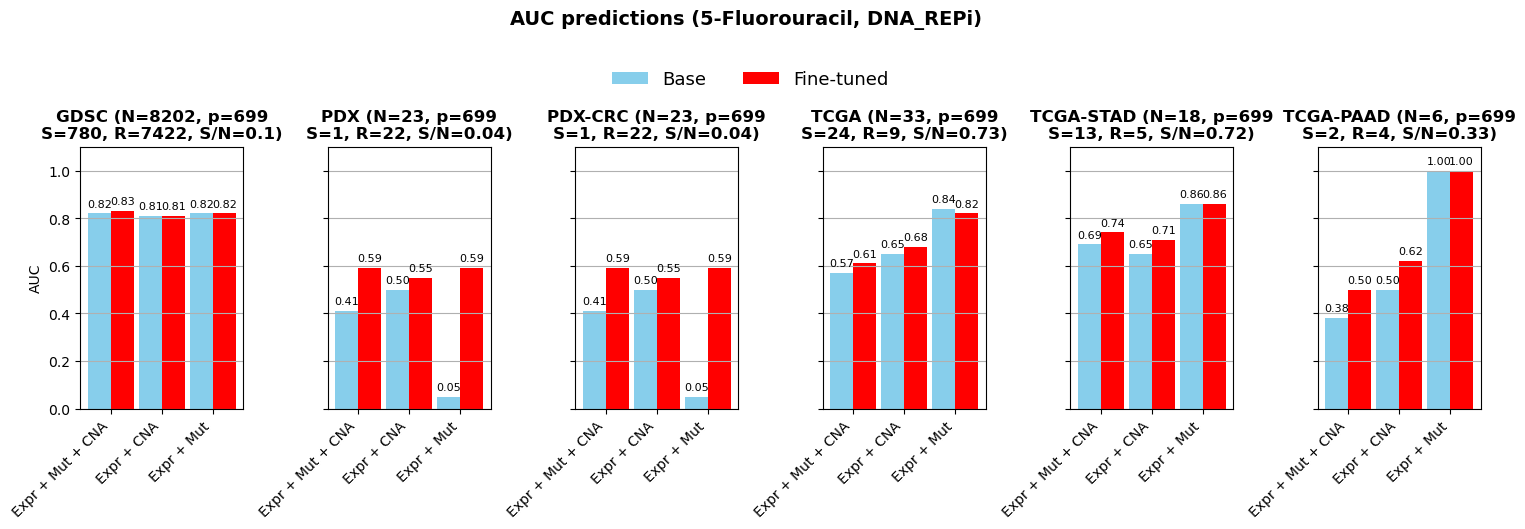

In [68]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (5-Fluorouracil, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (5-Fluorouracil, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [69]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUCPR (PDX, N={str(len(Ytsfluorouracil_pdx))})",
                               f"AUCPR (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})",
                               f"AUCPR (TCGA, N={str(len(Ytsfluorouracil_tcga))})",
                               f"AUCPR (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytsfluorouracil_pdx))})": f"PDX (N={str(len(Ytsfluorouracil_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRfluorouracil["response"].value_counts()[1]) + ", R=" + str(PDXRfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRfluorouracil["response"].value_counts()[1]/sum(PDXRfluorouracil["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-CRC, N={str(len(Ytsfluorouracil_pdx_crc))})": f"PDX-CRC (N={str(len(Ytsfluorouracil_pdx_crc))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytsfluorouracil_tcga))})": f"TCGA (N={str(len(Ytsfluorouracil_tcga))}, p=" + str(PDXEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil["response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil["response"].value_counts()[1]/sum(TCGARfluorouracil["response"].value_counts()), 2)) + ")",     
        f"AUCPR (TCGA-STAD, N={str(len(Ytsfluorouracil_tcga_stad))})": f"TCGA-STAD (N={str(len(Ytsfluorouracil_tcga_stad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "STAD","response"].value_counts()), 2)) + ")",
        f"AUCPR (TCGA-PAAD, N={str(len(Ytsfluorouracil_tcga_paad))})": f"TCGA-PAAD (N={str(len(Ytsfluorouracil_tcga_paad))}, p=" + str(TCGAEfluorouracil.shape[1]) + "\nS=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]) + ", R=" + str(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()[1]/sum(TCGARfluorouracil.loc[TCGARfluorouracil["cohort"] == "PAAD","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=8202, p=699\nS=780, R=7422, S/N=0.1)","PDX (N=23, p=699\nS=1, R=22, S/N=0.04)","PDX-CRC (N=23, p=699\nS=1, R=22, S/N=0.04)","TCGA (N=33, p=699\nS=24, R=9, S/N=0.73)","TCGA-PAAD (N=6, p=699\nS=2, R=4, S/N=0.33)"
Data,,,,,
Expr + Mut + CNA,0.35,0.07,0.07,0.79,0.42
Expr + Mut + CNA (Fine-tuned),0.34,0.1,0.1,0.81,0.45
Expr + CNA,0.33,0.08,0.08,0.87,0.45
Expr + CNA (Fine-tuned),0.33,0.09,0.09,0.88,0.7
Expr + Mut,0.33,0.05,0.05,0.93,1.0
Expr + Mut (Fine-tuned),0.34,0.1,0.1,0.93,1.0


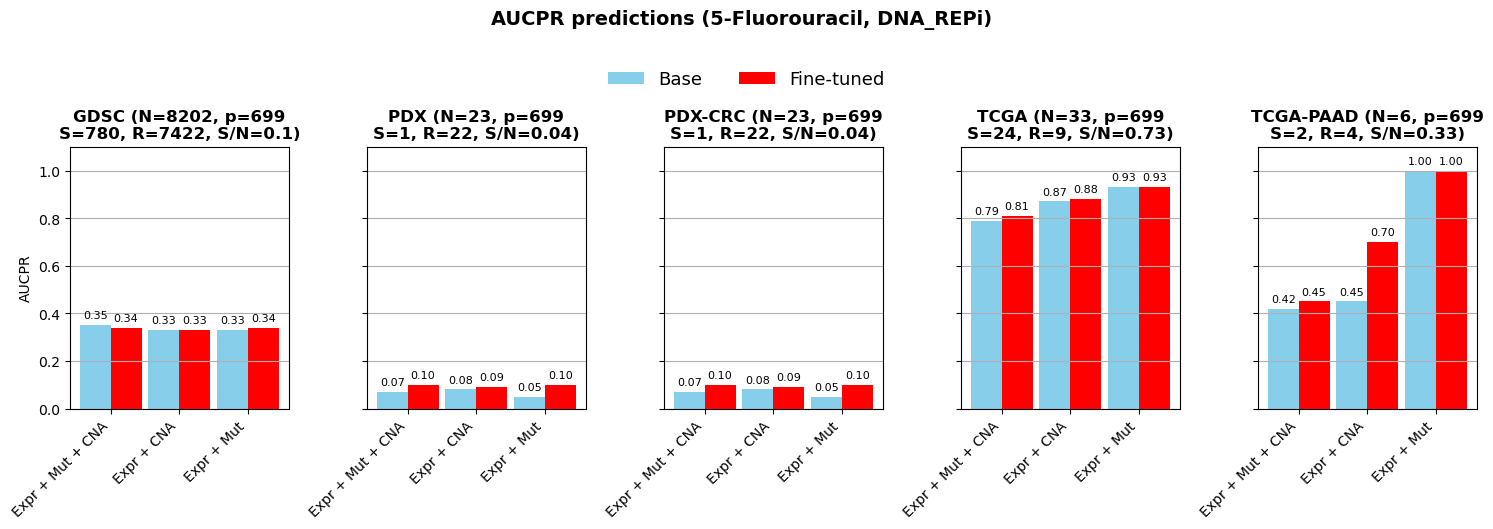

In [70]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (5-Fluorouracil, DNA_REPi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (5-Fluorouracil, DNA_REPi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [71]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/DNA_REPi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Third_Strategy


In [72]:
# save predictions

file = open('GDSC_PDX_TCGA_DNA_REPi_Fluorouracil_Predictions_Third_Strategy (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (DNA_REPi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (DNA_REPi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (5-Fluorouracil): {round(AUCTfluorouracil_pdx,2)}\n")
file.write(f"PDX Test (EM) AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc,2)}\n")
file.write(f"PDX Test (EM) AUCPR (5-Fluorouracil, CRC): {round(AUCTfluorouracil_pdx_crc_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (5-Fluorouracil): {round(AUCTfluorouracil_tcga,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (5-Fluorouracil): {round(AUCTfluorouracil_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (5-Fluorouracil, STAD): {round(AUCTfluorouracil_tcga_stad_aucpr,2)}\n")

file.write(f"TCGA Test (EM) AUC (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (5-Fluorouracil, PAAD): {round(AUCTfluorouracil_tcga_paad_aucpr,2)}\n")

file.close()